## Import libraries


In [ ]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Import additional libraries of your choice

## Load and prepare data

In [ ]:
train_df = pd.read_csv("training_data.csv", sep=";", parse_dates=True)
test_df = pd.read_csv("test_data.csv", sep=";", parse_dates=True)

In [ ]:
train_df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0


### Some quick methods to filter out relevant features and understand the data better

In [ ]:
train_df['deviceType'].value_counts() ### checking the different device types and their frequency in data.

iPhone8,1                                94879
iPhone7,2                                84679
iPhone9,3                                77608
iPhone8,4                                43427
iPhone9,4                                41597
                                         ...  
Xunity AuroraM                               1
SUGAR SUGAR_2                                1
intel w5                                     1
rockchip S9                                  1
xiaomi 红米1S联通4G版(TD - SCDMA)(2014813)        1
Name: deviceType, Length: 28297, dtype: int64

In [ ]:
train_df['softwareVersion'].value_counts() ### checking the different software version and their frequency in data.

8.0.0                    625296
12.1.2                   503082
8.1.0                    440687
7.0                      402921
6.0.1                    273603
                          ...  
Q                             1
12.2                          1
1.0                           1
9.0.4                         1
4.2.2-2013-11-18-v1.0         1
Name: softwareVersion, Length: 195, dtype: int64

In [ ]:
a = train_df['sourceGameId'].value_counts()
b = train_df[train_df['install'] == 1]['sourceGameId'].value_counts()
c = b/a
c.sort_values(ascending = False)

1580130      1.0
1550064      1.0
1374071      1.0
1638903      1.0
1272907      1.0
            ... 
131627088    NaN
131627269    NaN
131627276    NaN
131627313    NaN
131627427    NaN
Name: sourceGameId, Length: 34848, dtype: float64

In [ ]:
train_df[train_df['sourceGameId'] == 1580130]

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
980464,5c388cbef53b82003777a44d,2019-01-11T12:31:58.017+00:00,5c137ad235fb69000d7b0133,ios,12.1.2,1580130,JP,2,1,0,0,2019-01-11T08:17:36.522+00:00,2,2,cellular,"iPhone10,1",1


checking whether campignId can be treated as a categorical feature

In [ ]:
len(train_df['campaignId'].drop_duplicates())

9692

In [ ]:
len(train_df['campaignId'])

3738763

In [ ]:
train_df['campaignId'].value_counts()

5c3bfb0b36c2c6cc18710e7b    41740
5c385d02ee4549000d8b9ddd    36861
5c0f2ff2f4ee9d00225714c2    32856
5afbea849f23a400284f2619    30284
5c26db700f371292325680ec    28535
                            ...  
5c18f034d672b8001b03db71        1
5bb1ee3d789d68c23b9cf5f1        1
5c3326914a27eeeeaeaddadf        1
5add2b9975e83e414c54b173        1
5bf4d1d736da2687e1c61814        1
Name: campaignId, Length: 9692, dtype: int64

In [ ]:
a = train_df['campaignId'].value_counts()
b = train_df[train_df['install'] == 1]['campaignId'].value_counts()
c = b/a
c.sort_values(ascending = False)

5b9778f977f51928748943d0    1.0
5b69661ef03209016e11c5e5    1.0
5c3850b9abd7ce91678df270    1.0
5a9be6ea3f98c037e2583b14    1.0
5be7f1850aeed684d9797509    1.0
                           ... 
5c45a142b6f24f09a8ed36fb    NaN
5c45b72ee7ee85141f713077    NaN
5c45c65fa7192c1bb1e0d641    NaN
5c45cfc689ee5a002b8b6682    NaN
5c45df74cc31520ac5704f6a    NaN
Name: campaignId, Length: 9692, dtype: float64

checking whether sourceGameId can be treated as a categorical feature

In [ ]:
len(train_df['sourceGameId'].drop_duplicates())

34848

In [ ]:
len(train_df['sourceGameId'])

3738763

 From the data description and some quick analysis above following things are clear:

1.   There are multiple variables so it would require extensive exploratory analysis
2.  ```installCount``` and ```sourceGameId``` seems to be the most important features because it tells us about the installs.
3. ```timestamp``` as a variable on its own contains a lot of information regarding the day, hour and week. Therefore creating a variable for different hour of day, different day of month and week can reveal some interesting information about the user's ad starting habits which might be useful to obtain the install probabilities. Further it seems that subtracting the ```lastStart``` may reveal something interesting behavioural information about the user.
4. ```sourceGameId``` and ```campaignId``` reveal some interesting information when treated as categorical variables
5. After the above analysis it is clear that a lot of information is contained within the categorical variables. Now of the three choices which are commonly used (i.e Label encoding,one hot encoding and embedding), embedding seems like a natural choice for the problem as some features contains a lot of class which could make the data sparse if I proceed with one-hot encoding.
6. 


### Checking whether the target class is balanced or imbalanced

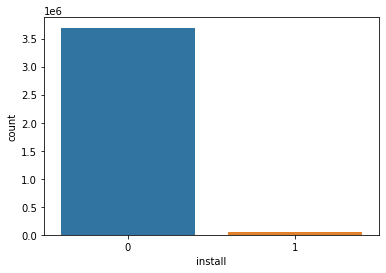

In [ ]:
train_df.shape
cor = train_df.corr()
sns.countplot(x = 'install', data = train_df)

From the plot above we can clearly see that the classes are highly imbalanced. Hence, the first ideas is to explore sampling and augmenting the class using oversampling. Now Synthetic minority oversampling technique(SMOTE) is a widely applied technique to deal with this kind of  problem. A significant advantage of SMOTE is that rather than just duplicating the records it samples from the minority class to create new datapoints. Therefore SMOTE is being employed to tackle the class imbalance problem. 

### Checking correlation between variables to remove redundant features by deriving new features

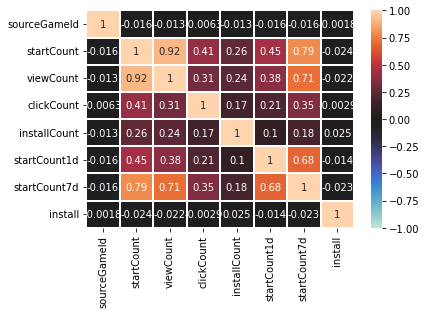

In [ ]:
sns.heatmap(train_df.corr(),vmin=-1, vmax=1, center= 0, linewidths=1,annot = True)

Following findings are obtained from the above plot:


*   Variables which are highly correlated:
  * ```viewCount``` and ```startCount```  - Both the variables tell us about different things, but the correlation between them probably points to the notion  that that whenever the user has started the campign, mostly that have viewed the whole campign. Hence Keeping one of them seems a plausible choice.
  * ```startCount``` and ```startCount7d``` also show a significant correlation. Hence, ```startCount``` can be dropped.

This may not be the case hence some testing will be performed to confirm such hypothesis.



---



Dealing with missing values by masking them as "other" for categorical data and creating new features from the timestamp to capture the information better and include them as a variable

In [ ]:
# you may find useful:
conv_date = lambda x: datetime.strptime(x.split(".")[0], "%Y-%m-%dT%H:%M:%S")
train_df.timestamp = train_df.timestamp.apply(conv_date)
test_df.timestamp = test_df.timestamp.apply(conv_date)

train_df["country"].mask(train_df["country"].isna(), "others", inplace=True)
test_df["country"].mask(test_df["country"].isna(), "others", inplace=True)

train_df["deviceType"].mask(train_df["deviceType"].isna(), "others", inplace=True)
test_df["deviceType"].mask(test_df["deviceType"].isna(), "others", inplace=True)

#variables extracted from the timestamp feature
train_df["day_of_month"] = train_df.timestamp.apply(lambda x: x.day)
train_df["day_of_week"] = train_df.timestamp.apply(lambda x: x.weekday())
train_df["hour_of_day"] = train_df.timestamp.apply(lambda x: x.hour)
test_df["day_of_month"] = test_df.timestamp.apply(lambda x: x.day)
test_df["day_of_week"] = test_df.timestamp.apply(lambda x: x.weekday())
test_df["hour_of_day"] = test_df.timestamp.apply(lambda x: x.hour)

# Time difference between the timstamp and last start 
train_df['timestamp'] = train_df['timestamp'].dt.tz_localize(None)
train_df['lastStart'] = pd.to_datetime(train_df['lastStart']).dt.tz_localize(None)
train_df['diff_btw_tstamp_lstart'] = train_df['timestamp'] - pd.to_datetime(train_df['lastStart'])
test_df['timestamp'] = test_df['timestamp'].dt.tz_localize(None)
test_df['lastStart'] = pd.to_datetime(test_df['lastStart']).dt.tz_localize(None)
test_df['diff_btw_tstamp_lstart'] = test_df['timestamp'] - pd.to_datetime(test_df['lastStart'])


### Preprocessing functions

Segerating each of the feature types and defining the embedding criteria for the categorical data

In [ ]:
output_feature = "install"

cont_features = ["viewCount", "clickCount", "installCount",
             "sucess_count_1d", "sucess_count_7d", "diff_btw_tstamp_lstart"]

categorical_features = ["campaignId", "platform", "sourceGameId", "country",  
             "connectionType","deviceType", "day_of_month", "day_of_week",
             "hour_of_day"]

In [ ]:
cat_dims = [int(train_df[col].nunique()) for col in categorical_features]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
print(cat_dims)
print(emb_dims)

In [ ]:
cat_dims_test = [int(test_df[col].nunique()) for col in categorical_features]
emb_dims_test = [(x, min(50, (x + 1) // 2)) for x in cat_dims_test]
print(cat_dims_test)
print(emb_dims_test)

[9708, 2, 34696, 221, 3, 28297, 14, 7, 24]
[(9708, 50), (2, 1), (34696, 50), (221, 50), (3, 2), (28297, 50), (14, 7), (7, 4), (24, 12)]


 The above cell show that test data and train data have different input categories for variables ```campaignId```, ```sourceGameId``` and ```deviceType``` but the input is predefined for embedding layer. Hence while making predictions on the test set I have divided the data into two parts to overcome this problem.

Instead of having redundant continous variables ```startCount```, ```startCount1d``` and ```startCount7d```. Two new features(```sucess_count_1d``` and ```sucess_count_7d'```) are created which display the ratio of the respective variable with ```startCount```. This allows us to capture the ```startCount``` and remove redundancy

In [ ]:
def modify_count_col(data):
    data['sucess_count_1d'] = data['startCount1d'] / data['startCount']
    data['sucess_count_7d'] = data['startCount7d'] / data['startCount']
    del data['startCount1d']
    del data['startCount']
    del data['startCount7d']
    return data

Label encoding of categorical data. 

This is done before passing the categorical data as input to the embedding layer

In [ ]:
categorical_features = ["campaignId", "platform", "sourceGameId", "country",  
             "connectionType","deviceType", "day_of_month", "day_of_week",
             "hour_of_day"]
def lab_encode(data,categorical_features): ## Function for label encoding for categorical data
    label_encoders = {}
    for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        data[cat_col] = label_encoders[cat_col].fit_transform(data[cat_col])
    return data

In [ ]:
def drop_irr_cols(data,columns):## function for dropping the columns which are not required.
    data.drop(columns, axis = 1, inplace = True)
    return data

In [ ]:
### Scaling Function for scaling continous feature to alow the model to learn better

cont_features = ["viewCount", "clickCount", "installCount",
             "sucess_count_1d", "sucess_count_7d", "diff_btw_tstamp_lstart"]

# Function for scaling the numerical features 
def Scale(data,scaler):
    data[["sucess_count_1d"]] = scaler.fit_transform(data[["sucess_count_1d"]])
    data['sucess_count_1d'].fillna(data['sucess_count_1d'].mean(), inplace=True)

    data[["sucess_count_7d"]] = scaler.fit_transform(data[["sucess_count_7d"]])
    data['sucess_count_7d'].fillna(data['sucess_count_7d'].mean(), inplace=True)

    data[["viewCount"]] = scaler.fit_transform(data[["viewCount"]])
    data['viewCount'].fillna(data['viewCount'].mean(), inplace=True)

    data[["clickCount"]] = scaler.fit_transform(data[["clickCount"]])
    data['clickCount'].fillna(data['clickCount'].mean(), inplace=True)

    data[["installCount"]] = scaler.fit_transform(data[["installCount"]])
    data['installCount'].fillna(data['installCount'].mean(), inplace=True)

    data[["diff_btw_tstamp_lstart"]] = scaler.fit_transform(data[["diff_btw_tstamp_lstart"]])
    data['diff_btw_tstamp_lstart'].fillna(data['diff_btw_tstamp_lstart'].mean(), inplace=True)

    data.dropna(inplace=True)

    return data

In [ ]:
scaler = MinMaxScaler()

In [ ]:
input_to_nn = train_df.copy()

removed_cols = ['id','timestamp','softwareVersion','lastStart']
input_to_nn = drop_irr_cols(input_to_nn, removed_cols)
input_to_nn = lab_encode(input_to_nn,categorical_features)
input_to_nn =  modify_count_col(input_to_nn)
input_to_nn = Scale(input_to_nn, scaler)


In [ ]:
input_to_nn.head() ## Final features which are served as input to the embedding Tabular class

,campaignId,platform,sourceGameId,country,viewCount,clickCount,installCount,connectionType,deviceType,install,day_of_month,day_of_week,hour_of_day,diff_btw_tstamp_lstart,sucess_count_1d,sucess_count_7d
0,48,1,8393,204,0.008276,0.00000,0.027397,0,23359,0,1,2,21,0.999720,0.039730,0.319059
1,48,1,27454,204,0.003103,0.00194,0.000000,0,23361,0,3,4,17,0.999727,0.099747,0.399170
2,48,1,8393,204,0.008966,0.00000,0.000000,0,23355,0,3,4,11,0.999729,0.036766,0.072793
3,48,1,5426,204,0.004828,0.00194,0.000000,2,23356,0,9,3,15,0.999717,0.199775,0.933241
4,48,1,8393,204,0.006207,0.00000,0.000000,0,23358,0,3,4,21,0.999710,0.649902,0.899862


In [ ]:
input_to_nn_X = input_to_nn.copy()
input_to_nn_X.drop(['install'], axis = 1, inplace = True)
input_to_nn_Y = input_to_nn['install']

Applying oversampling and data augmentation technique SMOTE to balance the imbalanced classes

In [ ]:
over_sampler = SMOTE()

X_temp, Y_temp = over_sampler.fit_resample(input_to_nn_X,input_to_nn_Y)
print('original dataset shape:', Counter(input_to_nn_Y))
print('Resample dataset shape', Counter(Y_temp))

original dataset shape: Counter({0: 3694019, 1: 44744})
Resample dataset shape Counter({0: 3694019, 1: 3694019})


### Splitting the data into training and validation set.
Please note that the data is served as input with the class label in the **tabular** class where it is segregated.

---



In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25)

In [ ]:
X_train['install'] = Y_train 

In [ ]:
X_train.head()

,campaignId,platform,sourceGameId,country,viewCount,clickCount,installCount,connectionType,deviceType,day_of_month,day_of_week,hour_of_day,diff_btw_tstamp_lstart,sucess_count_1d,sucess_count_7d,install
3791851,4751,0,30966,102,0.006864,0.004083,0.000000,0,24100,12,4,8,0.999710,0.292865,0.317651,1
3893021,7722,0,24357,125,0.001514,0.001240,0.000000,0,236,5,1,13,0.999710,0.312764,0.565550,1
1581167,4811,0,30334,48,0.057586,0.013579,0.041096,2,26775,1,2,14,0.999710,0.118309,0.365102,0
7171720,7244,1,27703,97,0.006687,0.000916,0.000000,1,23337,5,0,0,0.999719,0.048085,0.299373,1
6489733,1006,0,34036,121,0.002982,0.000762,0.000000,1,24115,8,2,22,0.785878,0.790313,0.842562,1


In [ ]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """
    self.n = data.shape[0]

    if output_col:
        self.y = data[output_col].astype(np.int64).values
    else:
        self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
        self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
        self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
        self.cat_X = data[cat_cols].astype(np.int64).values
    else:
        self.cat_X =  np.zeros((self.n, 1))

    def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n
    
    def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

In [ ]:
dataset = TabularDataset(data= X_train, cat_cols=categorical_features,
                             output_col = output_feature)
val_data = TabularDataset(data = X_val,cat_cols=categorical_features, output_col= None)

### Model Description



1.  The model is designed with keeping in mind that both numeric continous and categorical variables are to be fed as input to the network in order for the model to classify the data.

2. Pytorch's tabular class is quite useful in this kind of problem. The inputs features are treated as seperate inputs to the according to their data type. Embedding is applied on the categorical data and then it is concatenated with the numerical features which then passes as input to the network. The dropout is also used after embedding in order to prevent overfitting.

3. The network used in this case is particularly simple with two hidden layers with 64 and 128 units respectively.

4. For each layer ReLu activation is applied after that batch normalization is performed then dropout is introduced.

5. The dropout for embeding and the inputs are 0.04 and 0.001 and 0.01 respectively for each layer.

5. Loss function used is BCEWithLogitLoss which allows us to remove the sigmoid layer at the end of network. Further specifications are standard usage of ADam optimizer with a learning rate of 0.001.

6. The model is trained for 30 epochs with the configuration described above

5. To conclude, most thought while designing the model was given to the data types while trying to keep the network as simple as possible. 



In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self,emb_dims,no_of_cont,output_size,lin_layer_sizes,emb_dropout,lin_layer_dropouts):
        super(BinaryClassification, self).__init__()
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers
        first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                    lin_layer_sizes[0])

        self.lin_layers =\
        nn.ModuleList([first_lin_layer] +\
              [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
              for i in range(len(lin_layer_sizes) - 1)])
        
        for lin_layer in self.lin_layers:
          nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                      output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                        for size in lin_layer_sizes])

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                      for size in lin_layer_dropouts])

    def forward(self, cont_data, cat_data):

      if self.no_of_embs != 0:
        x = [emb_layer(cat_data[:, i])
            for i,emb_layer in enumerate(self.emb_layers)]
        x = torch.cat(x, 1)
        x = self.emb_dropout_layer(x)

      if self.no_of_cont != 0:
        normalized_cont_data = self.first_bn_layer(cont_data)

        if self.no_of_embs != 0:
          x = torch.cat([x, normalized_cont_data], 1) 
        else:
          x = normalized_cont_data

      for lin_layer, dropout_layer, bn_layer in\
          zip(self.lin_layers, self.droput_layers, self.bn_layers):
        
        x = F.relu(lin_layer(x))
        x = bn_layer(x)
        x = dropout_layer(x)

      x = self.output_layer(x)

      return x

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [ ]:
emb_dims = [(9692, 50), (2, 1), (34848, 50), (221, 50), (3, 2), (28298, 50), (14, 7), (7, 4), (24, 12)]

In [ ]:
model = BinaryClassification(emb_dims, no_of_cont=6, lin_layer_sizes=[64,128],
                          output_size=1, emb_dropout=0.04,
                          lin_layer_dropouts=[0.001,0.01])
model.to(device)

BinaryClassification(
  (emb_layers): ModuleList(
    (0): Embedding(9692, 50)
    (1): Embedding(2, 1)
    (2): Embedding(34848, 50)
    (3): Embedding(221, 50)
    (4): Embedding(3, 2)
    (5): Embedding(28298, 50)
    (6): Embedding(14, 7)
    (7): Embedding(7, 4)
    (8): Embedding(24, 12)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=232, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04, inplace=False)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001, inplace=False)
    (1): Dropout(p=0.01, inplace=False)
  )

In [ ]:
def accuracy_fn(y_pred, y_test): ## function for checking the accuracy
  y_pred_tag = torch.round(torch.sigmoid(y_pred))

  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/y_test.shape[0]
  acc = torch.round(acc * 100)
  
  return acc

In [ ]:
train_loader = DataLoader(dataset=dataset, batch_size= 256, shuffle=True)

In [ ]:
val_loader = DataLoader(dataset=val_data, batch_size= len(val_data))

In [ ]:
model.zero_grad()
lossFunc = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
LOSS = []
for i in range(30):
    l_loss =[]
    epoch_acc = 0
    model.train()
    for y, cont_x, cat_x in train_loader:
    optimizer.zero_grad()
    y, cont_x,cat_x = y.to(device), cont_x.to(device),cat_x.to(device)

    y_pred = model(cont_x,cat_x)

    loss = lossFunc(y_pred,y.unsqueeze(1).float())
    acc = accuracy_fn(y_pred, y.unsqueeze(1).float())
    l_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    epoch_acc += acc.item()

    LOSS.append(np.mean(l_loss))
    print(i,':',LOSS[-1])
    print(f'Acc: {epoch_acc/len(train_loader):.3f}')


In [ ]:
torch.save(model.state_dict(),"model.pt")

In [ ]:
model.load_state_dict(torch.load("model.pt",map_location=device))

<All keys matched successfully>

### Evaluation methodology


1. After preprocessing the training data was divided into seperate train and validation set.

2.  Most importance is given to the F1-score on validation set as it provides a great estimate of the model's predictive ability and senstivity.

3. After training multiple version of the model it was found that model performs best when the embedding approach is used. Features such as  ```softwareVersion``` did not improve the F1 score much hence they have been dropped.

4. Initially, i believe that the model was overfitting but the F1 score on validation set is 0.99 which justifies that the model is indeed performing well.

5. Further the confusion matrix plotted reveals that the model has mostly classified all the examples correctly on the validation set.

## Potential Improvements:
1. A thresholding mechanism can be deployed which classifies the the datapoint as install or not based on the probability


In [ ]:
# Your code starts here
y_pred_list = []
model.eval()
with torch.no_grad():
    for x in val_loader :
        vy, vcont, vcat = x 
        y, cont_x,cat_x = vy.to(device), vcont.to(device),vcat.to(device) 
        y_test_pred = model(cont_x,cat_x)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
final_pred_validation = []
for sub_list in y_pred_list[0]:
    final_pred_validation.append(sub_list)

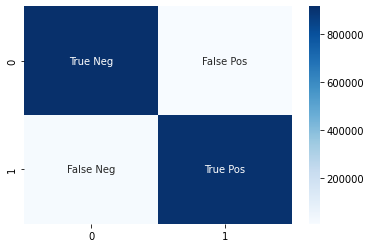

In [ ]:
c_mat = confusion_matrix(Y_val,final_pred_validation)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

categories = ['Zero', 'One']
sns.heatmap(c_mat, annot=labels, fmt='', cmap='Blues')
                      

In [ ]:
print(classification_report(Y_val, final_pred_validation))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    922359
           1       0.99      0.98      0.99    924651

    accuracy                           0.99   1847010
   macro avg       0.99      0.99      0.99   1847010
weighted avg       0.99      0.99      0.99   1847010



Predicting install probabilities for the test data



In [ ]:
test_df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,day_of_month,day_of_week,hour_of_day,diff_btw_tstamp_lstart
0,5c4609b6eb7476266130c224,2019-01-21 18:04:38,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21 17:58:23.728,6,6,wifi,LENOVO Lenovo A536,21,0,18,12 days 23:14:49.871000
1,5c454de3a21d3edde84568d9,2019-01-21 04:43:15,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaT,1,1,cellular,HUAWEI HUAWEI LUA-U22,21,0,4,11 days 07:22:52.145000
2,5c3c4f5769db2eee0c345059,2019-01-14 08:59:03,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14 08:56:10.539,4,17,wifi,samsung SM-T113,14,0,8,4 days 22:16:54.554000
3,5c4476bdf81acd685863a34f,2019-01-20 13:25:17,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaT,1,1,wifi,samsung SM-T113,20,6,13,3 days 17:27:05.364000
4,5c456954b7d257ead2f99568,2019-01-21 06:40:20,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21 06:38:38.298,3,7,cellular,OPPO X9009,21,0,6,9 days 09:37:14.897000


In [ ]:
input_to_nn_test = test_df.copy()

input_to_nn_test_1 = input_to_nn_test.iloc[:220000]
removed_cols = ['id','timestamp','softwareVersion','lastStart']
input_to_nn_test_1 = drop_irr_cols(input_to_nn_test_1, removed_cols)
input_to_nn_test_1 = lab_encode(input_to_nn_test_1,categorical_features)
input_to_nn_test_1 =  modify_count_col(input_to_nn_test_1)
input_to_nn_test_1 = Scale(input_to_nn_test_1, scaler)

input_to_nn_test_2 = input_to_nn_test.iloc[220000:]
removed_cols = ['id','timestamp','softwareVersion','lastStart']
input_to_nn_test_2 = drop_irr_cols(input_to_nn_test_2, removed_cols)
input_to_nn_test_2 = lab_encode(input_to_nn_test_2,categorical_features)
input_to_nn_test_2 =  modify_count_col(input_to_nn_test_2)
input_to_nn_test_2 = Scale(input_to_nn_test_2, scaler)

In [ ]:
tabular_test_1 = TabularDataset(data= input_to_nn_test_1, cat_cols=categorical_features,
                             output_col= None)
test_loader_1 = DataLoader(dataset= tabular_test_1, batch_size = len(tabular_test_1))

tabular_test_2 = TabularDataset(data= input_to_nn_test_2, cat_cols=categorical_features,
                             output_col= None)
test_loader_2 = DataLoader(dataset= tabular_test_2, batch_size = len(tabular_test_2))

In [ ]:
pred_list_1 = []
model.eval()
with torch.no_grad():
  for x in test_loader_1:
    vy, vcont, vcat = x 
    vy, cont_x,cat_x = vy.to(device), vcont.to(device),vcat.to(device) 
    y_pred = model(cont_x,cat_x)
    y_pred_tag = torch.sigmoid(y_pred)
    pred_list_1.append(y_pred_tag.cpu().numpy())

pred_list_1 = [a.squeeze().tolist() for a in pred_list_1]

In [ ]:
final_pred_test1 = []
for sub_list in pred_list_1[0]:
    final_pred_test1.append(sub_list)

In [ ]:
pred_list_2 = []
model.eval()
with torch.no_grad():
    for x in test_loader_2:
        vy, vcont, vcat = x 
        vy, cont_x,cat_x = vy.to(device), vcont.to(device),vcat.to(device) 
        y_pred = model(cont_x,cat_x)
        y_pred_tag = torch.sigmoid(y_pred)
        pred_list_2.append(y_pred_tag.cpu().numpy())

pred_list_2 = [a.squeeze().tolist() for a in pred_list_2]

In [ ]:
final_pred_test2 = []
for sub_list in pred_list_2[0]:
    final_pred_test2.append(sub_list)

In [ ]:
y_pred_test = final_pred_test1 + final_pred_test2

In [ ]:
# Your code starts here
test_predictions_df = pd.DataFrame(columns = ['id','install_proba'])

test_predictions_df['id'] = test_df['id']
test_predictions_df['install_proba'] = y_pred_test
#test_predictions_df.to_csv("unity_final_data.csv", index = None, header=True)

test_predictions_df.to_csv("test_predictions.csv", header=True, index=False, sep=";")

In [ ]:
df_pred = pd.read_csv('test_predictions.csv', sep =';')
df_pred.head() ### A peak into the predicted values

,id,install_proba
0,5c4609b6eb7476266130c224,0.999895
1,5c454de3a21d3edde84568d9,0.998117
2,5c3c4f5769db2eee0c345059,1.000000
3,5c4476bdf81acd685863a34f,0.991016
4,5c456954b7d257ead2f99568,1.000000
